# Singapore Speaker Prediction with WavLM
We perform demographic profiling on a subset of the NSC Part 3 (containing 30 speakers) using WavLM features extracted from 10-second audio clips. Classification performance is evaluated across **gender**, **age**, **ethnicity**, and **education** categories.


### Setup and Imports

In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [4]:
from transformers import AutoFeatureExtractor, AutoModel
import torch
import librosa
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

### Load Metadata and Audio Paths

In [5]:
speaker_df = pd.read_excel("Speakers (Part 3).xlsx")
clip_directory = Path("dataset/clips")

### Load `WavLM Base+` Model

In [9]:
model = "microsoft/wavlm-base-plus"
feature_extractor = AutoFeatureExtractor.from_pretrained(model)
model = AutoModel.from_pretrained(model)

### Define Feature Extraction Function

In [ ]:
def extract_features(wav_path):
    # Load audio at 16kHz
    wav, sr = librosa.load(wav_path, sr=16000)
    
    # Extract embeddings 
    inputs = feature_extractor(wav, sampling_rate=16000, return_tensors='pt') # pt indicates PyTorch tensors as output
    inputs["attention_mask"] = inputs["attention_mask"].bool()

    with torch.no_grad(): # Disable gradient tracking
        outputs = model(**inputs)
    
    embeddings = outputs.last_hidden_state

    # Mean pooling
    audio_embedding = embeddings.mean(dim=1)
    
    return audio_embedding

### Extract Speech Embeddings and Labels

In [10]:
records = []

for wav_file in clip_directory.rglob('*.wav'):
    speaker_id = int(wav_file.stem.split('_')[0])

    embeddings = extract_features(wav_file).squeeze().numpy() # Convert to 1D numpy array
   
    row = speaker_df[speaker_df["Speaker ID"] == speaker_id]
    if not row.empty:
        records.append({
            "embeddings": embeddings,
            "speaker_id": speaker_id,
            "age": row["Age"].values[0],
            "gender": row["Gender"].values[0],
            "ethnicity": row["Ethnicity"].values[0],
            "education": row["Education"].values[0],
            "clip_path": wav_file
        })

    else:
        print(f"Speaker ID {speaker_id} not found.")

/opt/miniconda3/envs/asp/lib/python3.10/site-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


### Create DataFrame

In [11]:
df = pd.DataFrame(records)
df["education"] = df["education"].replace({'PLSE': 'PSLE'})
education_order = ['PSLE', 'N-LEVEL', 'O-LEVEL', 'A-LEVEL', 'DIPLOMA', 'BACHELORS', 'POSTGRADUATE']
df["education"] = pd.Categorical(df["education"], categories=education_order, ordered=True)
age_order = ['1X', '2X', '3X', '4X', '5X', '6X']
df["age"] = pd.Categorical(df["age"], categories=age_order, ordered=True)

### Speaker-Level Pooling (not used here)

In [98]:
new_df = pd.DataFrame(df.groupby('speaker_id').first())
new_df['embeddings'] = df.groupby('speaker_id')['embeddings'].mean()
new_df.head()

,embeddings,age,gender,ethnicity,education,clip_path
speaker_id,,,,,,
862025,"[-0.03931061327457428, 0.01289314180612564, -0...",2X,M,MALAY,A-LEVEL,dataset/clips/00862025/00862025_clip_9.wav
862026,"[-0.031716462969779965, 0.014338815212249756, ...",1X,F,CHINESE,O-LEVEL,dataset/clips/00862026/00862026_clip_14.wav
862027,"[-0.03399554789066315, 0.01809448152780533, -0...",1X,M,CHINESE,DIPLOMA,dataset/clips/00862027/00862027_clip_8.wav
862029,"[-0.04430921971797943, 0.019183821976184845, -...",2X,M,CHINESE,NaN,dataset/clips/00862029/00862029_clip_16.wav
862031,"[-0.026571106910705567, 0.017916226387023927, ...",1X,M,MALAY,O-LEVEL,dataset/clips/00862031/00862031_clip_20.wav


### Data Exploration

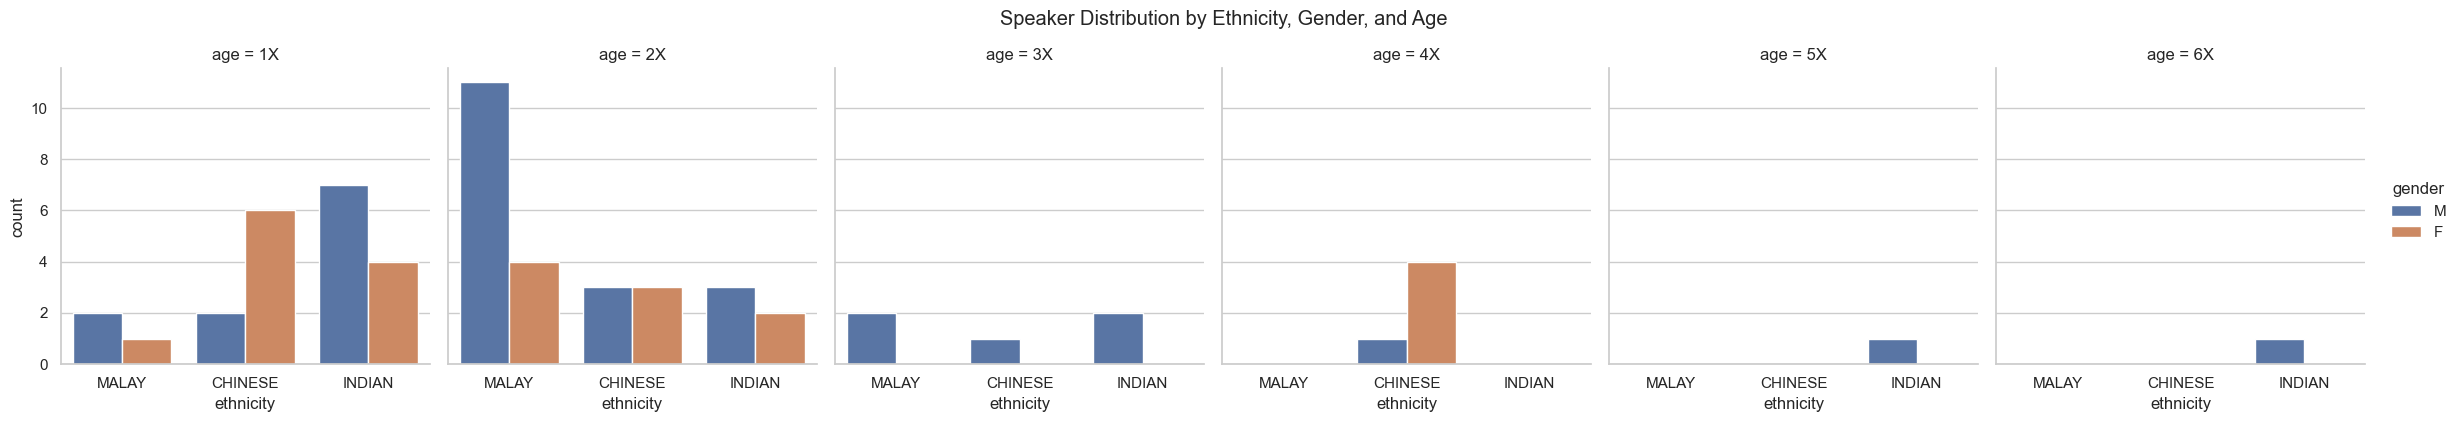

In [12]:
sns.set_theme(style="whitegrid")

plot_df = df.groupby("speaker_id", as_index=False).first()

sns.catplot(
    data=plot_df,
    kind="count",
    x="ethnicity",
    hue="gender",
    col="age",          
    height=4,
    aspect=1
)

plt.suptitle("Speaker Distribution by Ethnicity, Gender, and Age", y=1.05)
plt.show()

Text(0, 0.5, 'Number of Speakers')

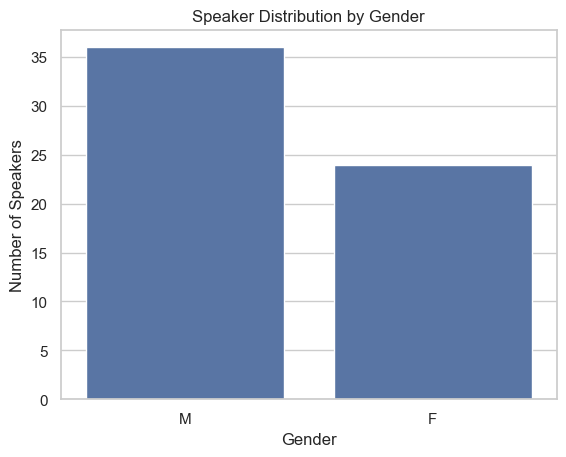

In [14]:
sns.countplot(plot_df, x="gender")
plt.title('Speaker Distribution by Gender')
plt.xlabel("Gender")
plt.ylabel("Number of Speakers")

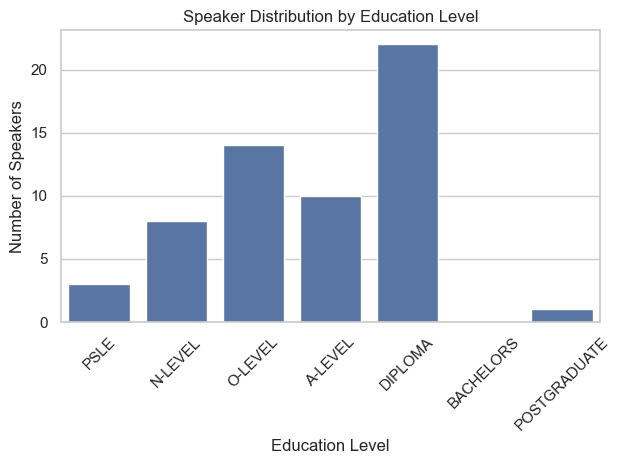

In [15]:
sns.countplot(plot_df, x="education")
plt.title("Speaker Distribution by Education Level")
plt.xlabel("Education Level")
plt.ylabel("Number of Speakers")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:
from sklearn.manifold import TSNE
import plotly.express as px
import numpy as np

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(np.vstack(df['embeddings']))

fig = px.scatter(
    x=X_tsne[:, 0],
    y=X_tsne[:, 1],
    color=df['ethnicity'],
    title="t-SNE visualization of WavLM embeddings (by Ethnicity)"
)
fig.update_traces(marker=dict(size=5))
fig.show()

### Define Classification Function

In [18]:
def run_classification(category, use_pca = False):
    temp_df = df.copy()
    
    if category == "age":
        valid_labels = ["1X", "2X", "3X", "4X"]
    elif category == "education":
        valid_labels = ["N-LEVEL", "O-LEVEL", "A-LEVEL", "DIPLOMA"]
    else:
        valid_labels = df[category].unique().tolist()
    
    temp_df = temp_df[temp_df[category].isin(valid_labels)]
    
    # Group to get one label per speaker
    speaker_labels = temp_df.groupby("speaker_id")[category].first()
    speaker_pool = speaker_labels.index.tolist()

    train_speakers, test_speakers = train_test_split(speaker_pool, test_size=0.2, stratify=speaker_labels, random_state=42)
    train_df = temp_df[temp_df["speaker_id"].isin(train_speakers)]    
    test_df = temp_df[temp_df["speaker_id"].isin(test_speakers)]   
    
    X_train = np.vstack(train_df["embeddings"])
    X_test = np.vstack(test_df["embeddings"])

    enc = LabelEncoder()
    y_train = enc.fit_transform(train_df[category])
    y_test = enc.transform(test_df[category])
    
    if use_pca:
        pca = PCA(n_components=150)
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)
    
    smote = SMOTE(random_state=42)
    X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

    classifiers = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Random Forest": RandomForestClassifier(),
        "Naive Bayes": GaussianNB(),
        "SVM": SVC(),
        "MLP": MLPClassifier(hidden_layer_sizes=(256,), max_iter=500)
    }

    for name, clf in classifiers.items():
        print(f"\n === {name} ===")
        clf.fit(X_train_bal, y_train_bal)
        y_pred = clf.predict(X_test)

        target_names = enc.classes_

        print(classification_report(y_test, y_pred, target_names=target_names))
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
        disp.plot(cmap='Blues')
        plt.title(f"{name} - {category} Confusion Matrix")
        plt.show()

### Gender Classification


 === Logistic Regression ===
              precision    recall  f1-score   support

           F       0.93      0.97      0.95       100
           M       0.98      0.95      0.96       140

    accuracy                           0.96       240
   macro avg       0.96      0.96      0.96       240
weighted avg       0.96      0.96      0.96       240



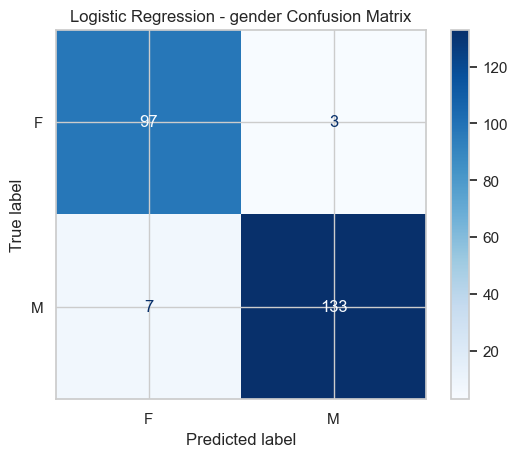


 === Random Forest ===
              precision    recall  f1-score   support

           F       0.95      0.93      0.94       100
           M       0.95      0.96      0.96       140

    accuracy                           0.95       240
   macro avg       0.95      0.95      0.95       240
weighted avg       0.95      0.95      0.95       240



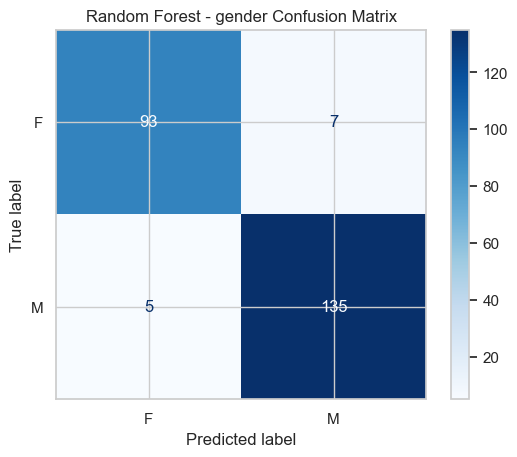


 === Naive Bayes ===
              precision    recall  f1-score   support

           F       0.83      0.76      0.79       100
           M       0.84      0.89      0.86       140

    accuracy                           0.83       240
   macro avg       0.83      0.82      0.83       240
weighted avg       0.83      0.83      0.83       240



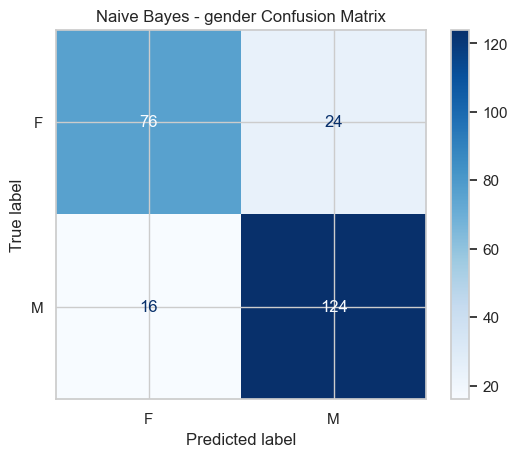


 === SVM ===
              precision    recall  f1-score   support

           F       0.95      0.99      0.97       100
           M       0.99      0.96      0.98       140

    accuracy                           0.97       240
   macro avg       0.97      0.98      0.97       240
weighted avg       0.98      0.97      0.98       240



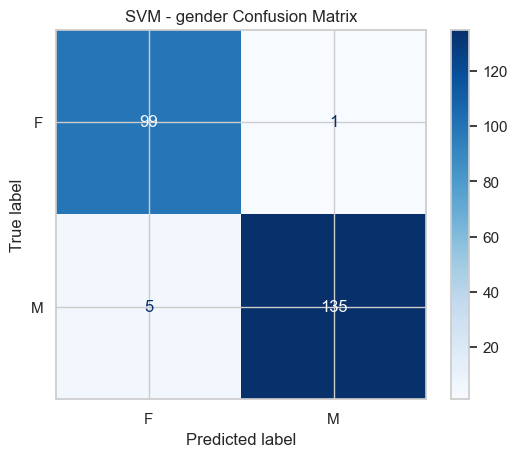


 === MLP ===
              precision    recall  f1-score   support

           F       0.98      0.99      0.99       100
           M       0.99      0.99      0.99       140

    accuracy                           0.99       240
   macro avg       0.99      0.99      0.99       240
weighted avg       0.99      0.99      0.99       240



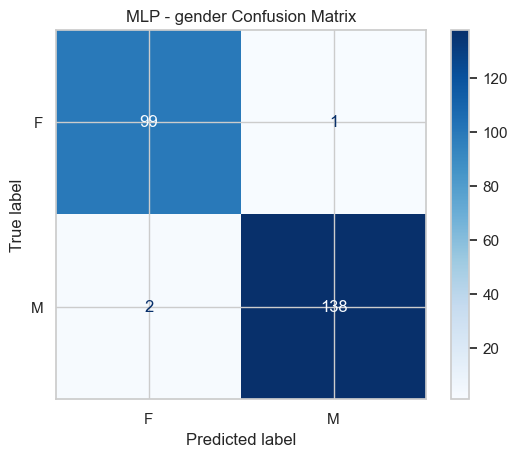

In [19]:
run_classification("gender")

### Age Classification


 === Logistic Regression ===
              precision    recall  f1-score   support

          1X       0.76      0.61      0.68       100
          2X       0.58      0.45      0.51       100
          3X       0.18      0.55      0.28        20
          4X       0.65      0.75      0.70        20

    accuracy                           0.55       240
   macro avg       0.55      0.59      0.54       240
weighted avg       0.63      0.55      0.58       240



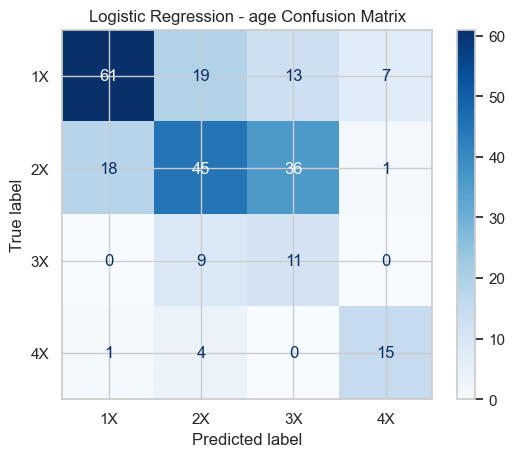


 === Random Forest ===
              precision    recall  f1-score   support

          1X       0.65      0.48      0.55       100
          2X       0.49      0.74      0.59       100
          3X       0.12      0.05      0.07        20
          4X       0.62      0.25      0.36        20

    accuracy                           0.53       240
   macro avg       0.47      0.38      0.39       240
weighted avg       0.54      0.53      0.51       240



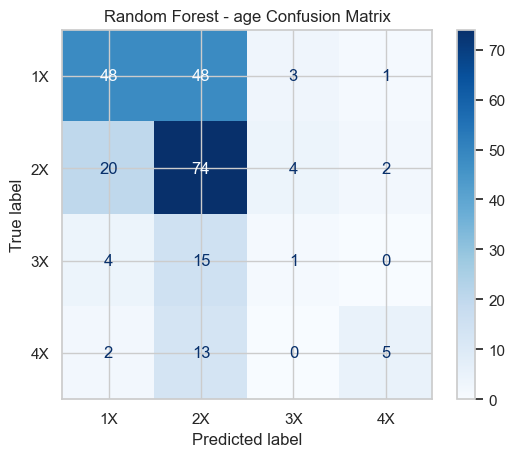


 === Naive Bayes ===
              precision    recall  f1-score   support

          1X       0.81      0.56      0.66       100
          2X       0.54      0.83      0.65       100
          3X       0.08      0.05      0.06        20
          4X       0.50      0.10      0.17        20

    accuracy                           0.59       240
   macro avg       0.48      0.39      0.39       240
weighted avg       0.61      0.59      0.57       240



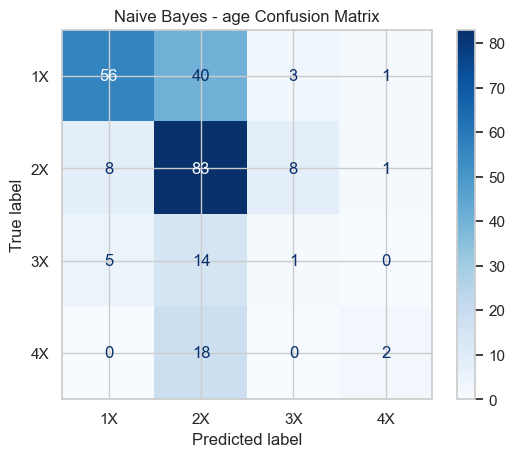


 === SVM ===
              precision    recall  f1-score   support

          1X       0.77      0.62      0.69       100
          2X       0.56      0.76      0.65       100
          3X       0.31      0.20      0.24        20
          4X       1.00      0.55      0.71        20

    accuracy                           0.64       240
   macro avg       0.66      0.53      0.57       240
weighted avg       0.66      0.64      0.63       240



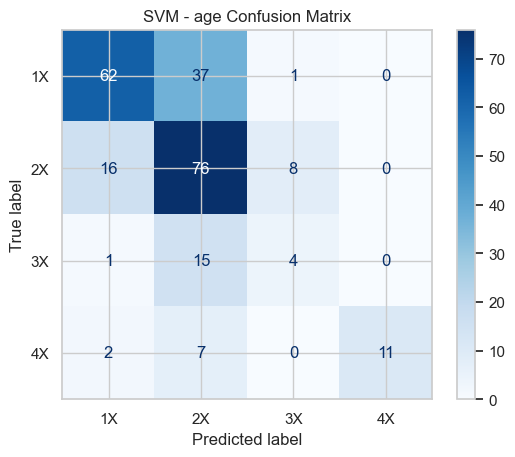


 === MLP ===
              precision    recall  f1-score   support

          1X       0.76      0.62      0.68       100
          2X       0.54      0.66      0.59       100
          3X       0.08      0.10      0.09        20
          4X       0.82      0.45      0.58        20

    accuracy                           0.58       240
   macro avg       0.55      0.46      0.49       240
weighted avg       0.61      0.58      0.59       240



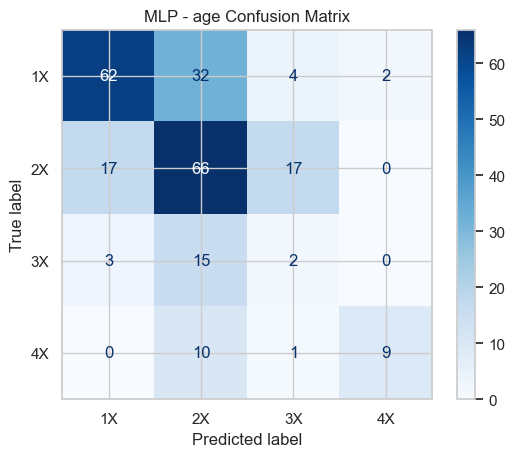

In [20]:
run_classification("age", use_pca=True)

### Ethnicity Classification


 === Logistic Regression ===
              precision    recall  f1-score   support

     CHINESE       0.63      0.99      0.77        80
      INDIAN       0.75      0.65      0.70        80
       MALAY       0.85      0.49      0.62        80

    accuracy                           0.71       240
   macro avg       0.74      0.71      0.70       240
weighted avg       0.74      0.71      0.70       240



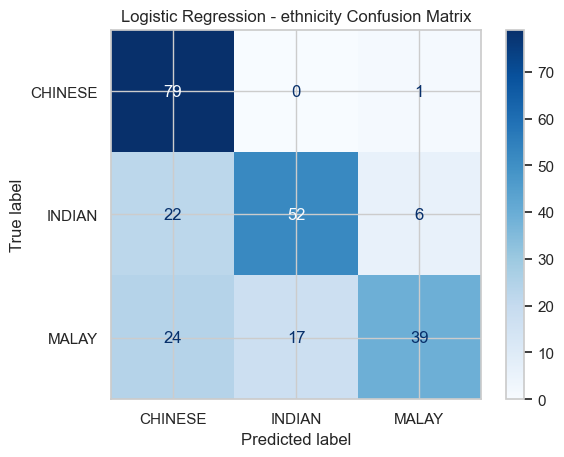


 === Random Forest ===
              precision    recall  f1-score   support

     CHINESE       0.58      0.99      0.73        80
      INDIAN       0.68      0.50      0.58        80
       MALAY       0.69      0.39      0.50        80

    accuracy                           0.62       240
   macro avg       0.65      0.62      0.60       240
weighted avg       0.65      0.62      0.60       240



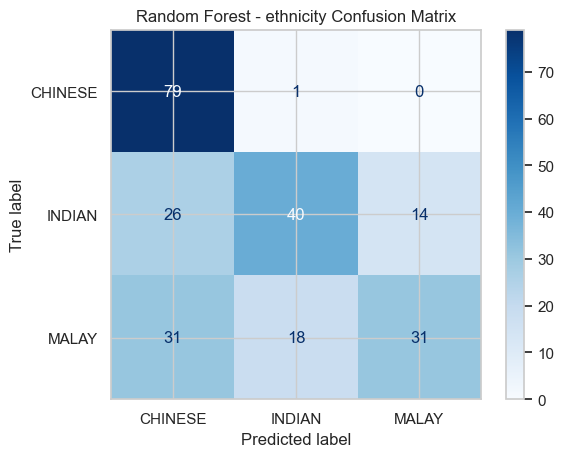


 === Naive Bayes ===
              precision    recall  f1-score   support

     CHINESE       0.57      1.00      0.72        80
      INDIAN       0.67      0.23      0.34        80
       MALAY       0.54      0.49      0.51        80

    accuracy                           0.57       240
   macro avg       0.59      0.57      0.52       240
weighted avg       0.59      0.57      0.52       240



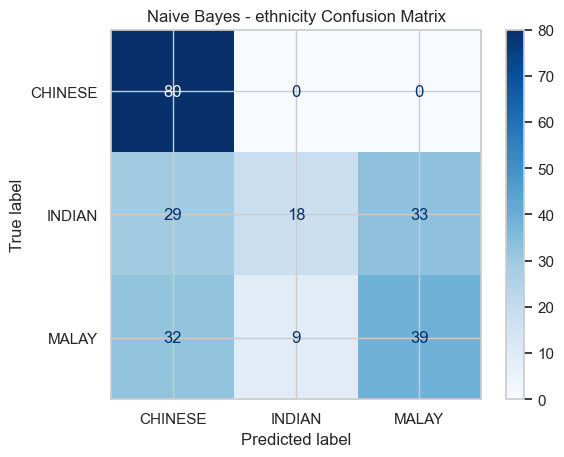


 === SVM ===
              precision    recall  f1-score   support

     CHINESE       0.66      1.00      0.79        80
      INDIAN       0.75      0.65      0.70        80
       MALAY       0.84      0.51      0.64        80

    accuracy                           0.72       240
   macro avg       0.75      0.72      0.71       240
weighted avg       0.75      0.72      0.71       240



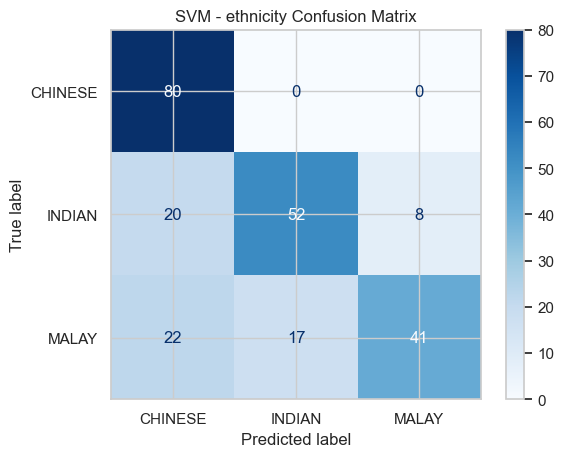


 === MLP ===
              precision    recall  f1-score   support

     CHINESE       0.60      0.95      0.73        80
      INDIAN       0.64      0.47      0.55        80
       MALAY       0.74      0.50      0.60        80

    accuracy                           0.64       240
   macro avg       0.66      0.64      0.63       240
weighted avg       0.66      0.64      0.63       240



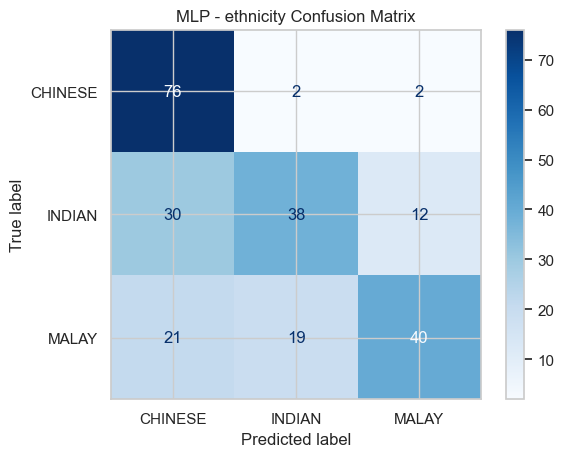

In [21]:
run_classification("ethnicity")

### Education Classification


 === Logistic Regression ===
              precision    recall  f1-score   support

     A-LEVEL       0.30      0.33      0.31        40
     DIPLOMA       0.47      0.44      0.45        80
     N-LEVEL       0.46      0.55      0.50        40
     O-LEVEL       0.35      0.32      0.33        60

    accuracy                           0.40       220
   macro avg       0.39      0.41      0.40       220
weighted avg       0.41      0.40      0.40       220



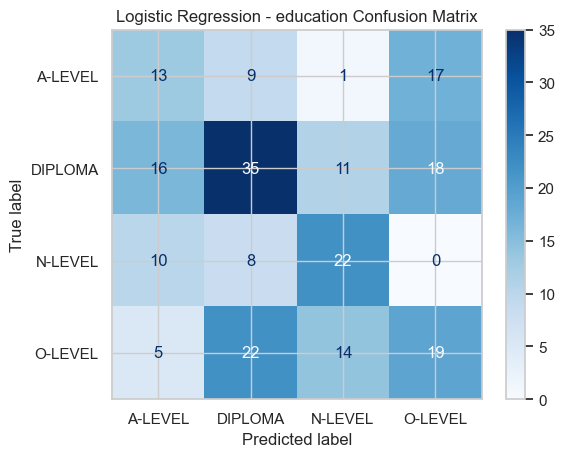


 === Random Forest ===
              precision    recall  f1-score   support

     A-LEVEL       0.39      0.23      0.29        40
     DIPLOMA       0.44      0.68      0.53        80
     N-LEVEL       0.52      0.28      0.36        40
     O-LEVEL       0.34      0.30      0.32        60

    accuracy                           0.42       220
   macro avg       0.42      0.37      0.37       220
weighted avg       0.42      0.42      0.40       220



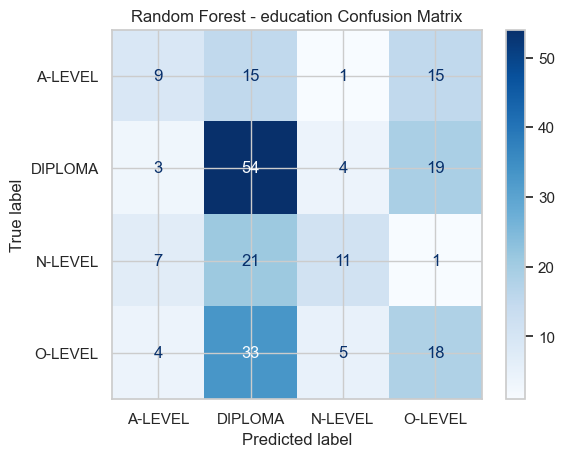


 === Naive Bayes ===
              precision    recall  f1-score   support

     A-LEVEL       0.33      0.35      0.34        40
     DIPLOMA       0.54      0.40      0.46        80
     N-LEVEL       0.49      0.50      0.49        40
     O-LEVEL       0.31      0.40      0.35        60

    accuracy                           0.41       220
   macro avg       0.42      0.41      0.41       220
weighted avg       0.43      0.41      0.41       220



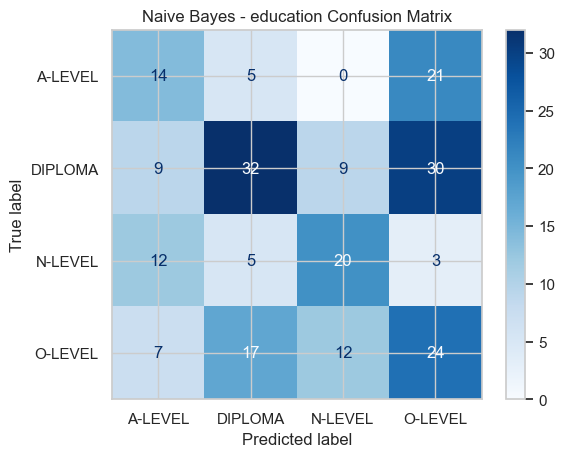


 === SVM ===
              precision    recall  f1-score   support

     A-LEVEL       0.33      0.35      0.34        40
     DIPLOMA       0.48      0.47      0.48        80
     N-LEVEL       0.46      0.45      0.46        40
     O-LEVEL       0.34      0.33      0.34        60

    accuracy                           0.41       220
   macro avg       0.40      0.40      0.40       220
weighted avg       0.41      0.41      0.41       220



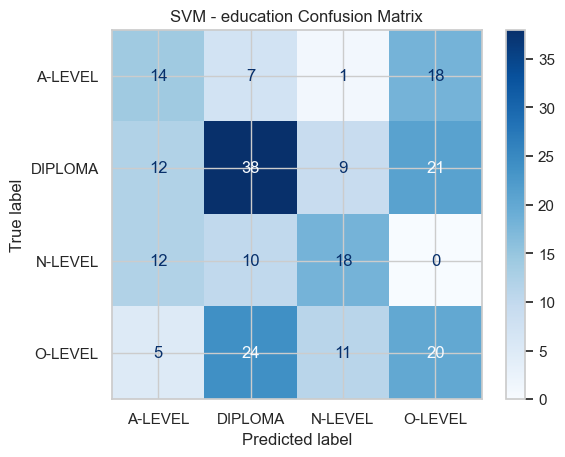


 === MLP ===
              precision    recall  f1-score   support

     A-LEVEL       0.31      0.23      0.26        40
     DIPLOMA       0.45      0.72      0.56        80
     N-LEVEL       0.46      0.28      0.34        40
     O-LEVEL       0.47      0.30      0.37        60

    accuracy                           0.44       220
   macro avg       0.42      0.38      0.38       220
weighted avg       0.43      0.44      0.41       220



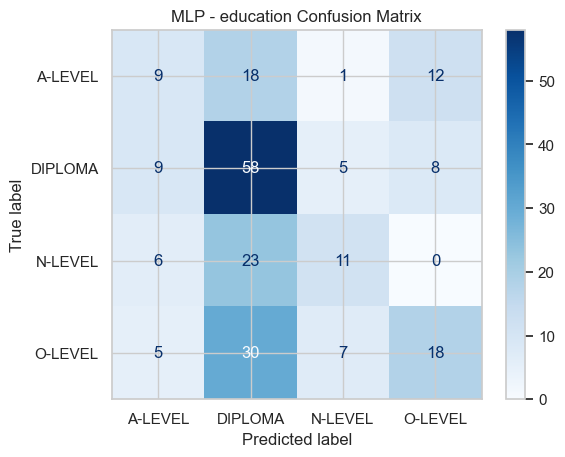

In [22]:
run_classification("education")